## Tutorial Notebook

This is a basic tutorial showcasing the various features of the `dual_autodiff` Python package. 

### Basic Usage

Once the package has been installed, import the dual_autodiff package:


In [5]:
import dual_autodiff as df

dual_autodiff package version: 0.1.0


We can create a dual number by calling the `Dual` class and passing a real and dual part as arguments. We can then return the real and dual parts in two different ways, as shown below:

In [2]:
# Define a dual number
x=df.Dual(2,1)

# Print the real and dual parts, either using the class attributes or designated member functions
print(x.real)
print(x.du())

2
1


We can apply basic arithmetical operations to dual numbers as we would with real numbers. This includes: addition, subtraction, multiplication, and division on either the LHS or RHS of the dual number; operate-and-assign operators; raising to a (real) exponent; comparison operators; and unary operators (i.e. inverting, or putting a '-' sign in front of a dual number).


In [3]:
y=df.Dual(3,4)
# addition
print(x+y)

Dual(real=5, dual=5)


In [4]:
# division
print(y/x)

Dual(real=1.5, dual=1.25)


In [5]:
# We can also apply such operations to real numbers on both the LHS and RHS of a dual number.
print(y-5, 5-y)

Dual(real=-2, dual=4) Dual(real=2, dual=-4)


In [6]:
# The operate-and-assign operators are also defined similarly.

x*=10

print(x)

Dual(real=20, dual=10)


In [7]:
# Exponentiation of dual numbers is defined for purely real exponents (i.e. the dual part must be 0).

z=df.Dual(4,9)

print(z**0.5)
print(z**df.Dual(0.5,0))

Dual(real=2.0, dual=2.25)
Dual(real=2.0, dual=2.25)


In [8]:
# We can check for (in)equivalence of dual numbers. 

x==z

False

In [9]:
# Note: '~' is the inversion operator (equivalent to raising an dual number to an exponent of (-1)).

print(~z)
print(z**(-1))

Dual(real=0.25, dual=-0.5625)
Dual(real=0.25, dual=-0.5625)


The `Dual` class also defines several common mathematical functions (see documentation for details) that can be extended to dual numbers.


In [10]:
import numpy as np

a=df.Dual(np.pi/2, 1)

print(a.sin())

print(df.Dual(1,5).exp())

Dual(real=1.0, dual=6.123233995736766e-17)
Dual(real=2.718281828459045, dual=13.591409142295225)


### Example - using the `Dual` class to compute derivatives

Dual numbers allow us to compute gradients to high levels of accuracy via the technique of Automatic Differentiation. 

This follows from Taylor's Theorem,
$ f(a + b \epsilon) = f(a) + f^\prime(a) (b \epsilon)$
where higher-order terms vanish since $\epsilon^2=0$. Thus the gradient at $x=a$ can be found by taking the dual part of $ f(a + \epsilon) $.

Below, we compute the gradient of $ f(x) = \log(\sin(x)) + x^2 \cos(x) $ at $x=1.5$ using 
 - dual numbers
 - the analytical derivative
 - numerically, with decreasing step size

and compare the results.

In [9]:
# Import the relevant packages
import numpy as np
import matplotlib.pyplot as plt

Firstly, I compute the derivative of the function using dual numbers.

In [12]:
# Define a function that we would like to differentiate at x==1.5. 
x=df.Dual(1.5,1)
output = (x.sin()).log() + (x**2) * x.cos()

# Compute the gradient using Taylors' Theorem
grad_dual=output.dual
print(grad_dual)

-1.9612372705533612


Secondly, I compute the analytical derivative of the function.

In [13]:
# Compare to the analytical result
def f_prime(x):
    return 1/np.tan(x) + 2*x*np.cos(x) - x**2 * np.sin(x)

grad_anal=f_prime(1.5)
print(grad_anal)

-1.9612372705533612


 This result agrees with the gradient obtained using dual numbers at the machine precision level (up to 1e-16)! This shows that the dual number method is very accurate, which is highly useful for performing automatic differentiation.

Thirdly, for comparison, I compute the numerical derivative of the function using a decreasing step size. I have also plotted the results and included the dual/analytical derivative for comparison.

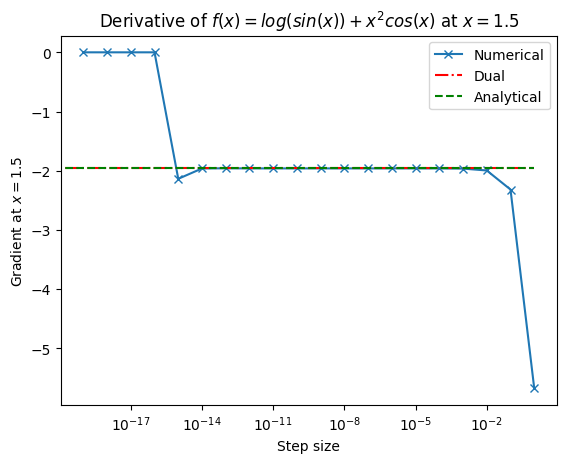

In [17]:
# Define the function f to compute the numerical gradient
def f(x):
    y = np.log(np.sin(x)) + x**2 *np.cos(x)
    return y

# Compute the numerical gradient at x==1.5    
x=1.5  

grad_num=[]
for i in range(20):
    eps=10**(-i)
    y = (f(x+eps) - f(x))/eps
    grad_num.append(y)

# Plot the gradient at each step size
step_size=[10**(-i) for i in range(20)]
plt.plot(step_size, grad_num, marker='x', label="Numerical")
plt.xlabel("Step size")
plt.xscale('log')
plt.ylabel("Gradient at $x=1.5$")
plt.title("Derivative of $ f(x) = log(sin(x)) + x^2 cos(x) $ at $x=1.5$")
plt.hlines(grad_dual, xmin=0, xmax=1, color='r', ls="-.", label= "Dual")
plt.hlines(grad_anal, xmin=0, xmax=1, color='g', ls="--", label= "Analytical")
plt.legend()
plt.show()


This looks like a good approximation to the derivative, but if we examine the errors, we find that it is not as accurate as the dual number method. I have plotted the error below.

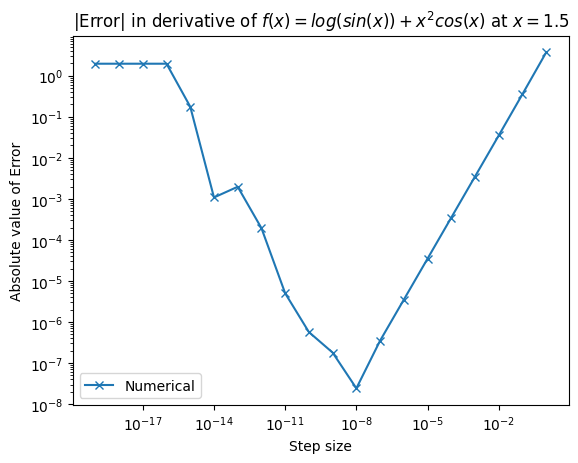

In [18]:
# Plot the error at each step size
step_size=[10**(-i) for i in range(20)]
plt.plot(step_size, np.abs(grad_num-grad_anal), marker='x', label="Numerical")
plt.xlabel("Step size")
plt.ylabel("Absolute value of Error")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(10**(-9), 10**(0))
plt.title("|Error| in derivative of $ f(x) = log(sin(x)) + x^2 cos(x) $ at $x=1.5$")
plt.legend()
plt.show()

In summary, the numerical method is limited by the step size, which can introduce errors if it becomes too large (because the higher order terms in the Taylor expansion are not yet small enough) or too small (due to rounding error). 

### Cythonized Package

I have also cythonized the package, called `dual_autodiff_x`. I compare the performance of the two packages below.

First I import the cythonized package and check that it works.

In [27]:
import dual_autodiff as df
import dual_autodiff_x as dfx
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [3]:
x=dfx.Dual(3,1)

Next, I create two functions that use the `Dual` class from the two packages, and compare their performance over many iterations using the `timeit` library. I have plotted the results for different numbers of iterations below.

In [8]:
def df_test(num_loops=1000):
    for _ in range(num_loops):
        x=df.Dual(2,1)
        y=df.Dual(3,4)

        x+y
        x-y
        x*y
        x/y
        x**5
        x+=y
        x-=y
        x*=y
        x/=y
        
        output = (x.sin()).log() + (x**2) * x.cos()

def dfx_test(num_loops=1000):
    for _ in range(num_loops):
        x=dfx.Dual(2,1)
        y=dfx.Dual(3,4)

        x+y
        x-y
        x*y
        x/y
        x**dfx.Dual(5,0)
        x+=y
        x-=y
        x*=y
        x/=y
        
        output = (x.sin()).log() + (x**dfx.Dual(2,0)) * x.cos()

In [9]:
execution_time_df =timeit.timeit('df_test(100000)', globals=globals(), number=10)
print(f'Execution time for 100000 iterations = {execution_time_df:.6f} seconds')

execution_time_dfx =timeit.timeit('dfx_test(100000)', globals=globals(), number=10)
print(f'Execution time for 100000 iterations = {execution_time_dfx:.6f} seconds')

Execution time for 100000 iterations = 16.296787 seconds
Execution time for 100000 iterations = 7.269393 seconds


In [10]:
df_time=[]
dfx_time=[]
for i in range(1,7):
    execution_time_df =timeit.timeit('df_test(10**i)', globals=globals(), number=10)
    df_time.append(execution_time_df)
    print(f'Execution time for {10**i} iterations = {execution_time_df:.6f} seconds')

    execution_time_dfx =timeit.timeit('dfx_test(10**i)', globals=globals(), number=10)
    dfx_time.append(execution_time_dfx)
    print(f'Execution time for {10**i} iterations = {execution_time_dfx:.6f} seconds')
    

Execution time for 10 iterations = 0.002829 seconds
Execution time for 10 iterations = 0.001452 seconds
Execution time for 100 iterations = 0.021189 seconds
Execution time for 100 iterations = 0.013784 seconds
Execution time for 1000 iterations = 0.268531 seconds
Execution time for 1000 iterations = 0.124755 seconds
Execution time for 10000 iterations = 2.173307 seconds
Execution time for 10000 iterations = 1.223758 seconds
Execution time for 100000 iterations = 15.202250 seconds
Execution time for 100000 iterations = 7.414084 seconds
Execution time for 1000000 iterations = 131.016705 seconds
Execution time for 1000000 iterations = 76.380444 seconds


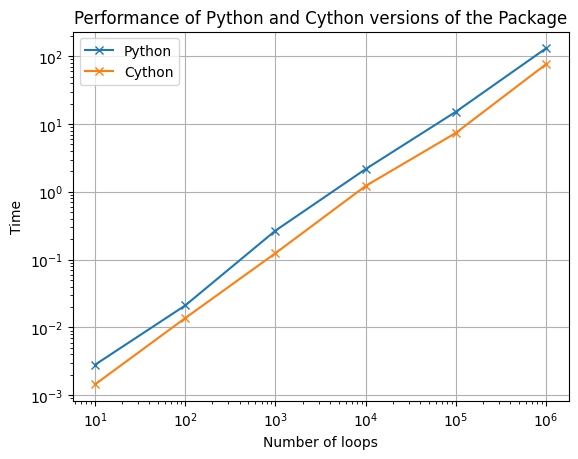

In [ ]:
size=[10**i for i in range(1,7)]
plt.loglog(size, df_time, '-x', label='Python')
plt.loglog(size, dfx_time, '-x', label='Cython')
plt.xlabel('Number of loops')
plt.ylabel('Time')
plt.title('Performance of Python and Cython versions of the Package')
plt.legend()
plt.grid()

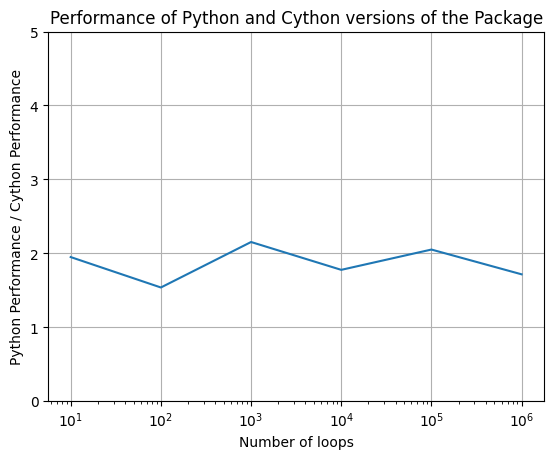

In [ ]:
ratio=np.divide(df_time,dfx_time)
plt.plot(size, ratio)
plt.xscale('log')
plt.ylim((0,5))
plt.xlabel('Number of loops')
plt.ylabel('Python Performance / Cython Performance')
plt.title('Performance of Python and Cython versions of the Package')
plt.grid()

In summary, we can see that the cythonized package is indeed faster than the pure python version (about twice as fast). This is because the cythonized package is compiled in C, which provides an initial speedup. Further, adding static typing in the cythonized package provided an additional speedup because the variable types are known at compile time, unlike in Python where variables are dynamically typed. 